# OCR Model Inference

This notebook demonstrates how to load a trained model and run inference on sample images from the test set.

In [1]:
import torch
import torchvision.transforms.functional as F
import json
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from model import OCRModel
from train import LabelConverter
from train import resize_and_pad_aspect

In [2]:
# Load Config
with open('config.json', 'r') as f:
    config = json.load(f)

DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [3]:
# Reconstruct Vocabulary (Ideally save/load this)
train_df = pd.read_csv(config['data']['train_csv'])
all_text = "".join(train_df['GroundTruth'].astype(str).tolist())
converter = LabelConverter(all_text)
print(f"Vocab size: {converter.vocab_size}")

Vocab size: 40


In [4]:
# Load Model
model = OCRModel(
    vocab_size=converter.vocab_size,
    d_model=config['model']['d_model'],
    nhead=config['model']['nhead'],
    num_encoder_layers=config['model']['num_encoder_layers'],
    num_decoder_layers=config['model']['num_decoder_layers'],
    resnet_layers=config['model']['resnet_layers'],
    max_len=config['data']['max_len']
).to(DEVICE)

# Load Weights (Adjust fold index as needed)
fold = 0 
checkpoint_path = config['training']['save_path'].replace('.pth', f'_fold{fold}_best.pth')

if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
    print(f"Loaded model from {checkpoint_path}")
else:
    print(f"Checkpoint not found at {checkpoint_path}. Using random weights.")

model.eval()

Loaded model from checkpoints/ocr_model_fold0_best.pth


/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


OCRModel(
  (feature_extractor): ResNetFeatureExtractor(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1)

In [12]:
# Inference Function
def predict(model, image_path, converter, device):
    transform = transforms.Compose([
        transforms.Resize((config['data']['image_height'], config['data']['image_width'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image = Image.open(image_path).convert('RGB')
    #image = resize_and_pad_aspect(image, (config['data']['image_height'], config['data']['image_width']))
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Greedy Decoding
    # Start with SOS
    tgt_indices = [converter.SOS]
    
    for _ in range(config['data']['max_len']):
        tgt_tensor = torch.LongTensor(tgt_indices).unsqueeze(0).to(device)
        
        tgt_mask = model.generate_square_subsequent_mask(len(tgt_indices)).to(device)
        
        with torch.no_grad():
            output = model(image_tensor, tgt_tensor, tgt_mask=tgt_mask)
        
        # Get last token prediction
        next_token_logits = output[0, -1, :]
        next_token = next_token_logits.argmax().item()
        
        if next_token == converter.EOS:
            break
            
        tgt_indices.append(next_token)
        
    return converter.decode(torch.LongTensor(tgt_indices).unsqueeze(0)[0]), image

/var/folders/jt/_vhzybnn7dg3qwfs2vtf58q40000gn/T/ipykernel_1275/1646321367.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_name = row[0]
/var/folders/jt/_vhzybnn7dg3qwfs2vtf58q40000gn/T/ipykernel_1275/1646321367.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gt = row[1]


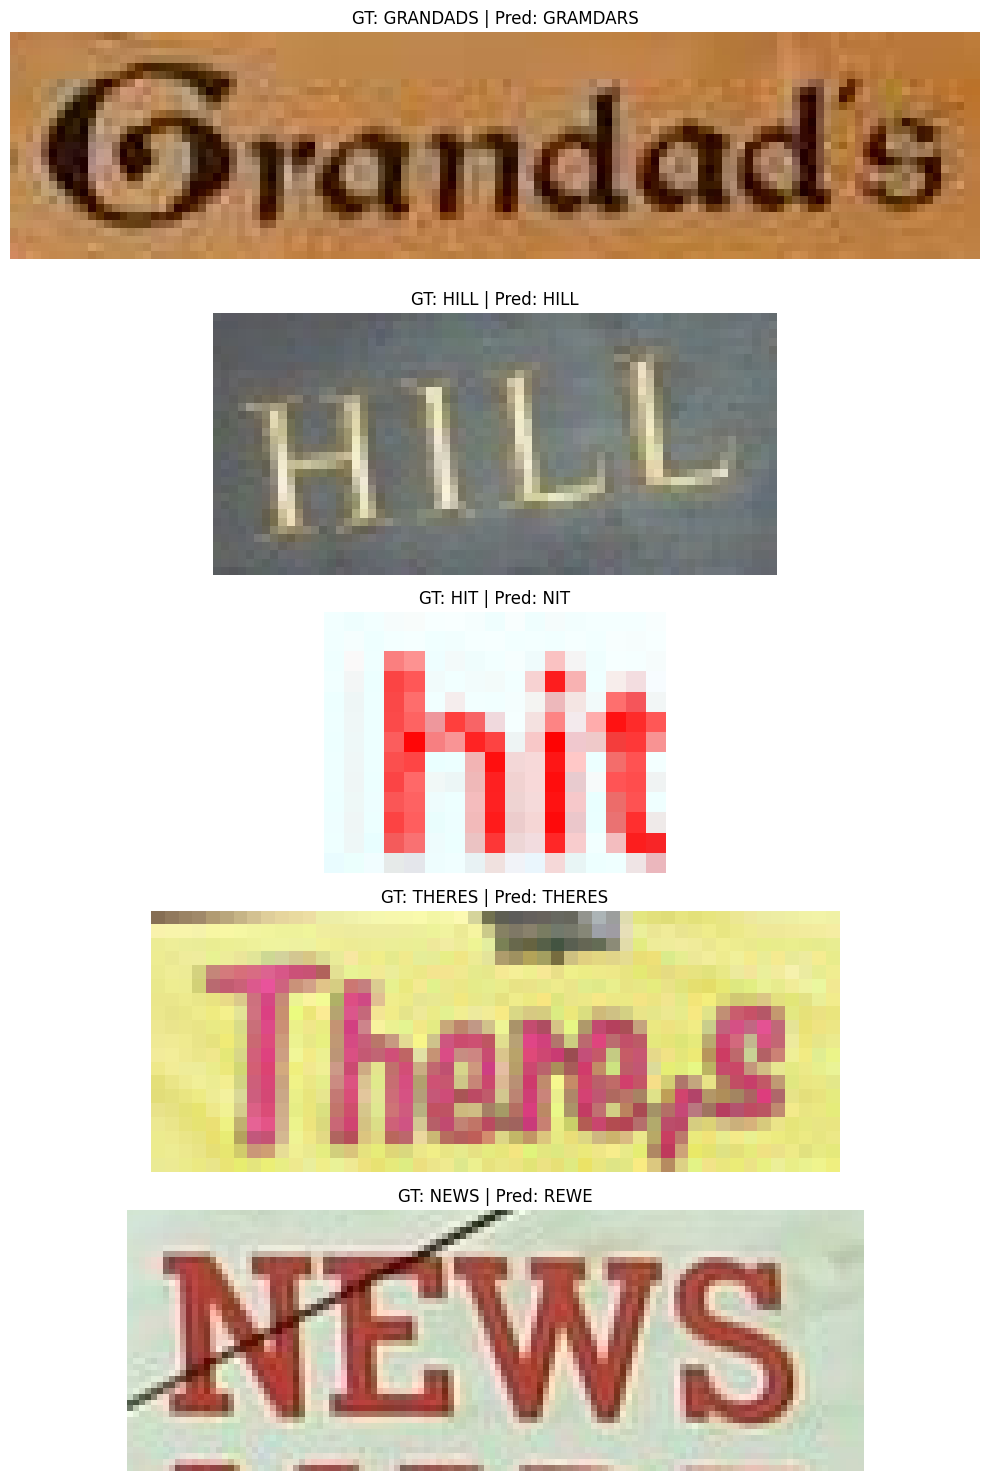

In [13]:
# Visualise on Test Data
test_df = pd.read_csv(config['data']['test_csv'])
test_dir = config['data']['test_dir']

num_samples = 5

fig, axes = plt.subplots(num_samples, 1, figsize=(10, 3*num_samples))

for i in range(num_samples):
    idx = torch.randint(0, len(test_df), (1,)).item()
    row = test_df.iloc[idx]
    img_name = row[0]
    gt = row[1]
    
    img_path = os.path.join(test_dir, img_name)
    
    try:
        pred, image = predict(model, img_path, converter, DEVICE)
        
        axes[i].imshow(image)
        axes[i].set_title(f"GT: {gt} | Pred: {pred}")
        axes[i].axis('off')
    except Exception as e:
        print(f"Error processing {img_name}: {e}")

plt.tight_layout()
plt.show()

In [5]:
import torch

# 2. Create dummy inputs
batch_size = 1
dummy_image = torch.randn(batch_size, 3, 64, 256)
# Use a length > 1 for the dummy target to help ONNX trace the sequence dimension
dummy_tgt = torch.zeros((batch_size, 5), dtype=torch.long) 

# 3. Export with Dynamic Axes
torch.onnx.export(
    model, 
    (dummy_image, dummy_tgt), 
    "ocr_model.onnx",
    export_params=True,
    opset_version=14,          # Opset 14+ handles dynamic Transformer reshapes better
    do_constant_folding=True,
    input_names=['images', 'tgt'], 
    output_names=['output'],
    dynamic_axes={
        'images': {0: 'batch_size'}, # Image width/height can also be made dynamic if needed
        'tgt': {0: 'batch_size', 1: 'seq_len'}, # THIS is the critical fix
        'output': {0: 'batch_size', 1: 'seq_len'}
    }
)

/var/folders/jt/_vhzybnn7dg3qwfs2vtf58q40000gn/T/ipykernel_11003/3680753580.py:10: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1229 15:49:14.819000 11003 site-packages/torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 14 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `OCRModel([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `OCRModel([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 14).
Failed to convert the model to the target version 14 using the ONNX C API. The model was not modified
Traceback (most recent call last):
  File "/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/opt/miniconda3/envs/myenv/lib/python3.11/site-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/en

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


Skipping constant folding for op Split with multiple outputs.
Skipping constant folding for op Split with multiple outputs.


Applied 77 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 18},
            producer_name='pytorch',
            producer_version='2.9.0',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"images"<FLOAT,[s34,3,64,256]>,
                %"tgt"<INT64,[s34,s59]>
            ),
            outputs=(
                %"output"<FLOAT,[1,s59,40]>
            ),
            initializers=(
                %"adapter.bias"<FLOAT,[256]>{TorchTensor(...)},
                %"transformer.encoder.layers.0.self_attn.in_proj_bias"<FLOAT,[768]>{TorchTensor(...)},
                %"transformer.encoder.layers.0.self_attn.out_proj.bias"<FLOAT,[256]>{TorchTensor(...)},
                %"transformer.encoder.layers.0.linear2.bias"<FLOAT,[256]>{TorchTensor(...)},
                %"transformer.encoder.layers.0.norm1.weight"<FLOAT,[256]>{TorchTensor(...)},
                %"transform